## A) Import libs 

In [24]:
#import libs
import numpy as np 
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt 
import math
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import ipywidgets as widgets
from ipywidgets import interact

# import files 
from DataSet import DataSet
from DataGen import DataGen 
from FixedGP import FixedGP 
from DataGen import DataGen
from utilities import standardize_vector, map_plot, labeled_inputs_plot, compare_output_label, plot_combinations

## B) Load matlab data with DataSet class

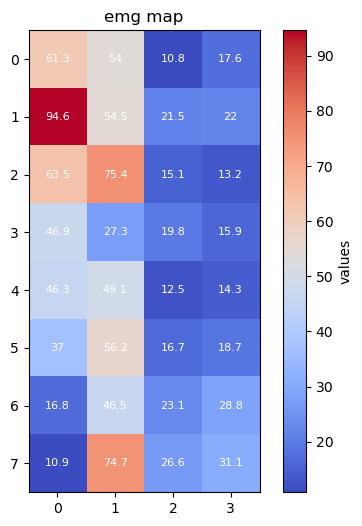

In [25]:
# Load dataset and extract relevant data
ds = DataSet('data/', 'rat', 'rat1_M1_190716.mat', 'rat1')  # Initialize the dataset with the path, animal type, file, and dataset name
ds.load_matlab_data()  # Load the data from the specified MATLAB file

emg = 5

# Extract relevant variables from the dataset
ch2xy = ds.set['ch2xy']  # Channel to (x, y) position mapping
sorted_respMean = ds.set['sorted_respMean']  # Sorted response means
output = sorted_respMean[:, emg]  # Select the 5th column of the sorted response means, i.e. the responses of the 5th emg 

# Initialize an empty map for EMG values, with shape based on the maximum x and y positions
map_emg = np.full((np.max(ch2xy[:, 0]), np.max(ch2xy[:, 1])), np.nan)

# Loop over each channel and assign its response mean value to the corresponding position in the EMG map
for i in range(ch2xy.shape[0]):
    # Convert the (x, y) position to zero-based indices and set the EMG value at that position
    map_emg[int(ch2xy[i, 0] - 1), int(ch2xy[i, 1] - 1)] = output[i]

# Plot the generated EMG map using the previously defined map_plot function
map_plot(map_emg, 'emg map')

## C) Generate data for the NN with DataGen class

In [26]:
name = 'A_5que_10kcomb_rat1_emg6'

In [27]:
dg = DataGen(map_emg)
dg.generate_pre_labeled_inputs(name=name, nb_queries=5, nb_comb=10000, 
                               kernel_type='Mat52', noise_std=0.1, 
                               output_std=3, lengthscale=[1.*1/7, 1.*1/3])
dg.format_labeled_inputs(name=name)

These pre-labeled inputs were made with these parameters:
 name: A_5que_10kcomb_rat1_emg6
 nb_queries: 5
 nb_comb: 10000
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]


## D) Generate data for the NN with DataGen class for all the EMGs of 1 rat

In [37]:
# Load dataset and extract relevant data
ds = DataSet('data/', 'rat', 'rat5_M1_191112.mat', 'rat5')  # Initialize the dataset with the path, animal type, file, and dataset name
ds.load_matlab_data()  # Load the data from the specified MATLAB file

for emg in range(len(ds.set['emgs'])):

    # Extract relevant variables from the dataset
    ch2xy = ds.set['ch2xy']  # Channel to (x, y) position mapping
    sorted_respMean = ds.set['sorted_respMean']  # Sorted response means
    output = sorted_respMean[:, emg]  # Select the 5th column of the sorted response means, i.e. the responses of the 5th emg 

    # Initialize an empty map for EMG values, with shape based on the maximum x and y positions
    map_emg = np.full((np.max(ch2xy[:, 0]), np.max(ch2xy[:, 1])), np.nan)

    # Loop over each channel and assign its response mean value to the corresponding position in the EMG map
    for i in range(ch2xy.shape[0]):
        # Convert the (x, y) position to zero-based indices and set the EMG value at that position
        map_emg[int(ch2xy[i, 0] - 1), int(ch2xy[i, 1] - 1)] = output[i]

    name = f'A_3que_4kcomb_{ds.dataset_name}_emg{emg+1}'

    dg = DataGen(map_emg)
    dg.generate_pre_labeled_inputs(name=name, nb_queries=3, nb_comb=4000, 
                                kernel_type='Mat52', noise_std=0.1, 
                                output_std=3, lengthscale=[1.*1/7, 1.*1/3])
    dg.format_labeled_inputs(name=name)


These pre-labeled inputs were made with these parameters:
 name: A_3que_4kcomb_rat5_emg1
 nb_queries: 3
 nb_comb: 4000
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]
These pre-labeled inputs were made with these parameters:
 name: A_3que_4kcomb_rat5_emg2
 nb_queries: 3
 nb_comb: 4000
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]
These pre-labeled inputs were made with these parameters:
 name: A_3que_4kcomb_rat5_emg3
 nb_queries: 3
 nb_comb: 4000
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]
These pre-labeled inputs were made with these parameters:
 name: A_3que_4kcomb_rat5_emg4
 nb_queries: 3
 nb_comb: 4000
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]
These pre-labeled inputs were made with these parameters:
 name: A_3que_4kcomb_rat5_emg5
 nb_que

## E) Group all the EMGs file for 1 rat in a single file

In [ ]:
def concatenate_and_save(input_files, output_file):
    """
    Concatène les données de plusieurs fichiers et les sauvegarde dans un fichier unique.

    Args:
        input_files (list of str): Liste des chemins des fichiers à charger.
        output_file (str): Chemin du fichier de sortie.
    """
    # Initialisation des listes pour stocker les données concaténées
    all_train_input = []
    all_train_label = []
    all_descriptions = []

    # Charger et concaténer les données
    for file in input_files:
        loaded_data = torch.load(file, weights_only=True)
        all_train_input.append(loaded_data["train_input"])
        all_train_label.append(loaded_data["train_label"])
        all_descriptions.append(loaded_data["description"])

    # Concaténer les tenseurs et les listes
    concatenated_train_input = torch.cat(all_train_input, dim=0)
    concatenated_train_label = torch.cat(all_train_label, dim=0)
    concatenated_description = "; ".join(all_descriptions)

    # Sauvegarder les données concaténées
    output_data = {
        "train_input": concatenated_train_input,
        "train_label": concatenated_train_label,
        "description": concatenated_description,
    }
    torch.save(output_data, output_file)

    print(f"Les données ont été sauvegardées dans {output_file}")



# Exemple d'utilisation

num_rat = 6
nb_k_comb = 10

input_files = [
    f"dataset/single_map/og_A_5que_{nb_k_comb}kcomb_rat{num_rat}_emg1.pth",
    f"dataset/single_map/og_A_5que_{nb_k_comb}kcomb_rat{num_rat}_emg2.pth",
    f"dataset/single_map/og_A_5que_{nb_k_comb}kcomb_rat{num_rat}_emg3.pth",
    f"dataset/single_map/og_A_5que_{nb_k_comb}kcomb_rat{num_rat}_emg4.pth",
    f"dataset/single_map/og_A_5que_{nb_k_comb}kcomb_rat{num_rat}_emg5.pth",
    f"dataset/single_map/og_A_5que_{nb_k_comb}kcomb_rat{num_rat}_emg6.pth",
    f"dataset/single_map/og_A_5que_{nb_k_comb}kcomb_rat{num_rat}_emg7.pth",
    f"dataset/single_map/og_A_5que_{nb_k_comb}kcomb_rat{num_rat}_emg8.pth",
]
output_file = f"dataset/emgALL/og_A_5que_{nb_k_comb}kcomb_rat{num_rat}_emgALL.pth"
concatenate_and_save(input_files, output_file)

Les données ont été sauvegardées dans dataset/og_A_5que_10kcomb_rat6_emgALL.pth


 C:\Users\deleu\AppData\Local\Temp\ipykernel_11940\85551705.py:16: FutureWarning:You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
